In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Load Data

In [2]:
fire_df = pd.read_csv("data/fire_data_checkpoint.csv")
fire_df.head(3)

,Fire_Year,Fire_Name,GIS_Acres,Fire_Type,Distance
0,1964,COYOTE (4),65338.877636,Wildfire,381.341881
1,1964,C. HANLY (5),55960.694158,Wildfire,91.248279
2,1964,COZY DELL (5),19218.105903,Wildfire,447.055720


In [3]:
len(fire_df)

117190

## Visualizations

1. Produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city for all fires ranging up to 1800 miles away from your assigned city. Your histogram should indicate the distance cut-off for your modeling work as specified in Step 1.

- The estimate only considers the last 60 years of wildland fire data (1961-2021).
- The estimate only considers fires that are within 650 miles of your assigned city.
- Defines the annual fire season as running from May 1st through October 31st.


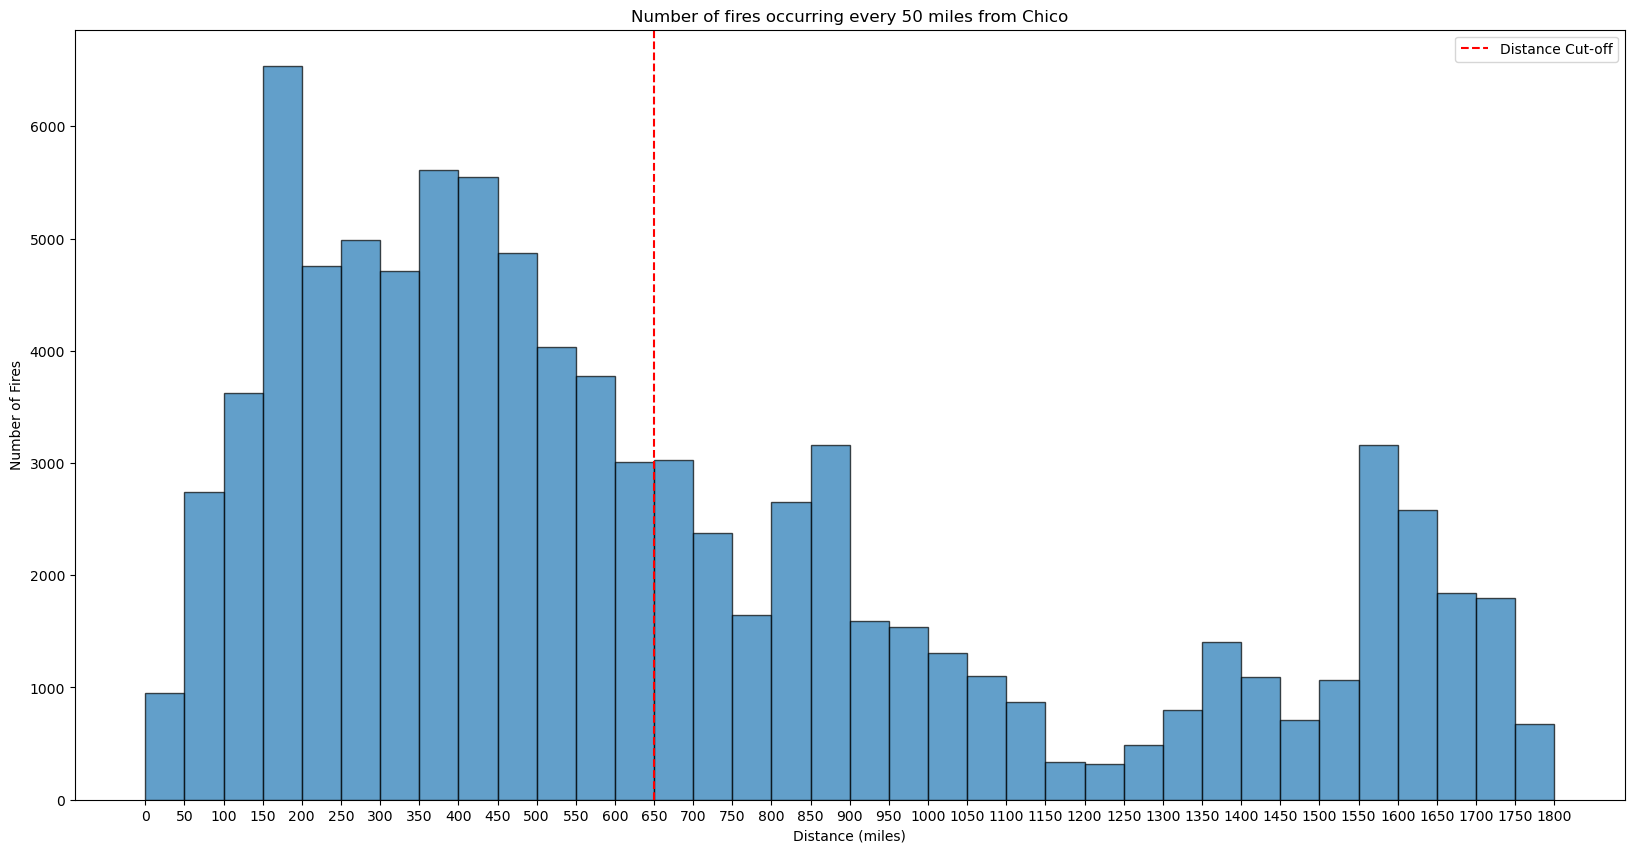

In [4]:
start_year = 1964
end_year = 2024
distance_cutoff = 1800
bin_width = 50

# fitler to last 60 years
filtered_fire_df = fire_df[(fire_df['Fire_Year'] >= start_year) & (fire_df['Fire_Year'] <= end_year)]

# filter to within 1800 miles of Chico
filtered_fire_df['Distance'] = pd.to_numeric(filtered_fire_df['Distance'])
filtered_fire_df = filtered_fire_df[filtered_fire_df['Distance'] <= distance_cutoff]


bins = range(0, distance_cutoff + bin_width, bin_width)

plt.figure(figsize=(20, 10))
plt.hist(filtered_fire_df['Distance'], bins=bins, edgecolor='black', alpha=0.7)
plt.title('Number of fires occurring every 50 miles from Chico')
plt.xlabel('Distance (miles)')
plt.ylabel('Number of Fires')
plt.axvline(x=650, color='r', linestyle='--', label='Distance Cut-off')
plt.legend()
plt.xticks(bins)
plt.show()

2. Produce a time series graph of total acres burned per year for the fires occurring in the specified distance from your city.


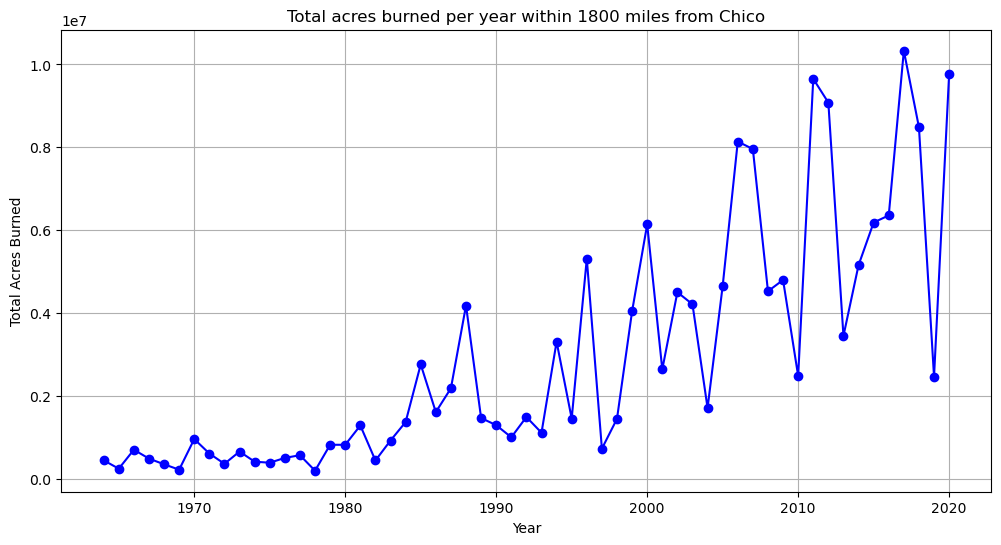

In [18]:
annual_acres_burned = filtered_fire_df.groupby('Fire_Year')['GIS_Acres'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(annual_acres_burned['Fire_Year'], annual_acres_burned['GIS_Acres'], marker='o', color='b', linestyle='-')
plt.title("Total acres burned per year within 1800 miles from Chico")
plt.xlabel("Year")
plt.ylabel("Total Acres Burned")
plt.grid(True)
plt.show()

3. Produce a time series graph containing your fire smoke estimates for your city and the AQI estimates for your city.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


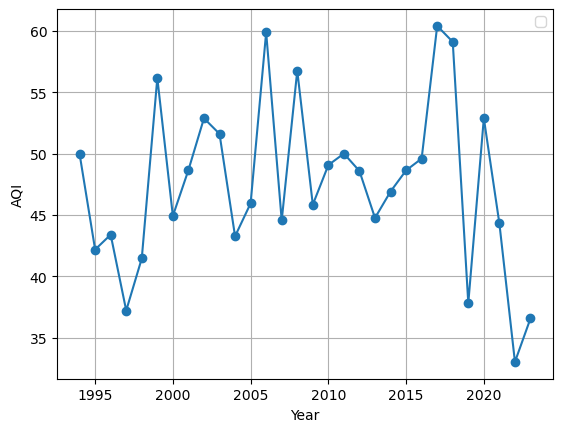

In [20]:
# combine gas_df, part_df, calculate average AQI of gas_df and part_df

gas_df = pd.read_csv('data/gaseous_pollutants_data.csv')
part_df = pd.read_csv('data/particulate_pollutants_data.csv')

# data from monitoring station site: San Andreas-Gold Strike Road

gas_df_daily = gas_df.copy()
gas_df_daily['date_local'] = pd.to_datetime(gas_df['date_local'])
gas_df_daily['year'] = gas_df_daily['date_local'].dt.year

gas_df_daily = gas_df_daily.dropna(subset=['aqi']).reset_index(drop=True)

gas_df_daily = gas_df_daily[['aqi', 'year', 'date_local']]


gas_df_daily = gas_df_daily.groupby('date_local', as_index=False).agg({
    'aqi': 'mean',
    'year': 'first'
})


gas_df_yearly = gas_df_daily[['aqi', 'year']]

gas_df_yearly = gas_df_daily.groupby('year', as_index=False).agg({
    'aqi': 'mean'
})



part_df_daily = part_df.copy()
part_df_daily['date_local'] = pd.to_datetime(part_df['date_local'])
part_df_daily['year'] = part_df_daily['date_local'].dt.year

part_df_daily = part_df_daily.dropna(subset=['aqi']).reset_index(drop=True)

part_df_daily = part_df_daily[['aqi', 'year', 'date_local']]


part_df_daily = part_df_daily.groupby('date_local', as_index=False).agg({
    'aqi': 'mean',
    'year': 'first'
})

part_df_yearly = part_df_daily[['aqi', 'year']]

part_df_yearly = part_df_daily.groupby('year', as_index=False).agg({
    'aqi': 'mean'
})

# join gas_df_yearly with part_df_yearly on year, get an average aqi

merge_df = gas_df_yearly.merge(part_df_yearly, on='year')

merge_df['average_aqi'] = merge_df[['aqi_x', 'aqi_y']].mean(axis=1)


aqi_df = merge_df[['year', 'average_aqi']]

plt.figure()
plt.plot(aqi_df['year'], aqi_df['average_aqi'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.show()